In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.fft as fft
import seaborn as sns
sns.set()

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tqdm.notebook import tqdm

import sys
sys.path.append("/home/evangelos/workspace/Channel_Charting/")
from tools import utils
from src.models import supervised_classifier, supervised_regressor
from src.utils.data_preparation import SupervisedDataset

In [5]:
def preprocessing(data, first_data, rx_positions=None, padding=True, reduce=False, keep_idces=None):
    data = data[idcs]
    if rx_positions:
        data = utils.drop_top_right(data, rx_positions)
    data = utils.standarize(data)
    data = utils.fillna(data)
    if padding:
        data = utils.zero_padding_as(data, first_data)
    #data = utils.take_norm(data)
    if reduce:
        data = reduce_to_mean_std(data)
    
    return data

def reduce_to_mean_std(x):
    return np.stack([np.mean(x,axis=1), 
                          np.std(x,axis=1)], axis=1)

In [6]:
# load datasets
(raw_taps, raw_phi, raw_theta, raw_rx_positions, raw_tx_positions) = utils.load_datasets()
#fourier transform and undersample taps
raw_freq_taps = fft.fft(raw_taps , workers=-1)[:,:,::2]

In [285]:
mean_freq = np.mean(raw_freq_taps, axis=(1,2))
mu = np.mean(mean_freq)
std = np.std(mean_freq)
idcs = ~(np.abs(mean_freq-mu) >3*std)

In [286]:
#preprocessing
taps = preprocessing(raw_freq_taps, raw_freq_taps, keep_idces=idcs, reduce=True)
taps = np.hstack([np.real(taps), np.imag(taps)])
phi = preprocessing(raw_phi, taps, keep_idces=idcs, reduce=True)
theta = preprocessing(raw_theta, taps, keep_idces=idcs, reduce=True)

y  = preprocessing(raw_rx_positions, taps, padding=False, reduce=False, keep_idces=idcs)[:,:2]
X = np.hstack([taps, phi[:-10], theta[:-10]])

In [287]:
n_clusters = 8

from sklearn.cluster import KMeans
km = KMeans(n_clusters=n_clusters)
km = km.fit(y)
labels = km.predict(y)

In [288]:
#train test split
train_X, test_X ,train_y, test_y, train_labels, test_labels = train_test_split(X, y, labels)
train_DS = SupervisedDataset(train_X, train_labels)
test_DS = SupervisedDataset(test_X, test_labels)

In [289]:
train_loader = DataLoader(train_DS, batch_size=64)
test_loader = DataLoader(test_DS, batch_size=64)

In [290]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=8, n_clusters=8):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=train_DS.channels(), 
                               out_channels=128, 
                               kernel_size=8,
                              stride=2)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.lin1 = nn.Linear(160, 64)
        self.lin2 = nn.Linear(64, 32)
        self.out = nn.Linear(32,latent_dim)
        self.labels = nn.Linear(32, n_clusters)
        
    def forward(self, x):
        x = (F.selu(self.conv1(x)))
        x = (F.selu(self.conv2(x)))
        x = (F.selu(self.conv3(x)))
        x = torch.flatten(x,1)
        x = (F.selu(self.lin1(x)))
        x = (F.selu(self.lin2(x)))

        x, labels = self.out(x), self.labels(x)
        return x, labels
    

In [291]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=8):
        super(Decoder, self).__init__()
        self.lin1 = nn.Linear(latent_dim ,32)
        self.lin2 = nn.Linear(32, 64)
        self.lin3 = nn.Linear(64, 160)
        
        self.deconv1 = nn.ConvTranspose1d(32, 64, 2, 2)
        self.deconv2 = nn.ConvTranspose1d(64, 128, 4, 2)
        self.deconv3 = nn.ConvTranspose1d(128, train_DS.channels(), 8, 2)   
        
    def forward(self, x):
        x = F.selu(self.lin1(x))
        x = F.selu(self.lin2(x))        
        x = F.selu(self.lin3(x))
        x = x.view(x.shape[0], 32, 5)
        x = F.selu(self.deconv1(x))
        x = F.selu(self.deconv2(x))        
        x = F.selu(self.deconv3(x))
        
        return x

In [292]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=32, n_clusters=8):
        super(Autoencoder, self).__init__()        
        self.encoder = Encoder(latent_dim, n_clusters)
        #warm_start
        #self.encoder.load_state_dict(torch.load("/home/evangelos/workspace/Channel_Charting/trained_models/supervised_model.pkl"), 
        #                             strict=False)

        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        enc, labels = self.encoder(x)
        dec = self.decoder(enc)
        
        return dec, labels

In [303]:
model = Autoencoder(latent_dim=32, n_clusters=n_clusters)
optimizer = torch.optim.Adam(params=model.parameters())
criterion_1 = nn.MSELoss()
criterion_2 = nn.CrossEntropyLoss()
alpha=1
beta=1

In [304]:
for e in range(50):
    # train
    model.train()
    loss=0
    for x, y in train_loader:
    
        optimizer.zero_grad()
        reconstructed, mapping = model(x)
        
        batch_loss_1 = criterion_1(x, reconstructed)
        batch_loss_2 = criterion_2(mapping, y.long())
        batch_loss = alpha*batch_loss_1 + beta*batch_loss_2
        batch_loss.backward()
        
        optimizer.step()
        
        loss+=batch_loss.item()
    
    #validate
    model.eval()
    val_loss = 0
    for x, _ in test_loader:
        reconstructed, _ = model(x)
        val_loss += criterion(x, reconstructed).item()
    
    print(f"Epoch {e}: Train_loss: {loss*train_loader.batch_size} Validation_loss: {val_loss*test_loader.batch_size}")

Epoch 0: Train_loss: 32772.34355163574 Validation_loss: 32.56466330587864
Epoch 1: Train_loss: 30773.377815246582 Validation_loss: 102.36919548735023
Epoch 2: Train_loss: 29435.723678588867 Validation_loss: 64.11640242487192
Epoch 3: Train_loss: 27846.790649414062 Validation_loss: 40.622496366500854
Epoch 4: Train_loss: 26340.33039855957 Validation_loss: 82.56779728084803
Epoch 5: Train_loss: 25216.549057006836 Validation_loss: 280.43828524649143
Epoch 6: Train_loss: 24547.05365753174 Validation_loss: 56.07533364929259
Epoch 7: Train_loss: 23867.76678085327 Validation_loss: 22.133160578086972
Epoch 8: Train_loss: 23561.51823425293 Validation_loss: 60.98739151097834
Epoch 9: Train_loss: 23037.627979278564 Validation_loss: 53.577066918835044
Epoch 10: Train_loss: 22561.142623901367 Validation_loss: 40.984978878870606
Epoch 11: Train_loss: 22176.877773284912 Validation_loss: 28.81303045898676
Epoch 12: Train_loss: 21781.610641479492 Validation_loss: 17.043326321989298
Epoch 13: Train_loss

In [305]:
reconstructed, labels = model(test_DS[:][0])
embedding, _ = model.encoder(test_DS[:][0])

In [306]:
sample = test_DS[0][0].detach()
reconstructed_sample = reconstructed[0]

In [307]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
t_sne = TSNE(n_components=2, perplexity=15)
pca = PCA(n_components=2)
yhats_TSNE = t_sne.fit_transform(embedding.detach())
yhats_PCA = pca.fit_transform(embedding.detach())

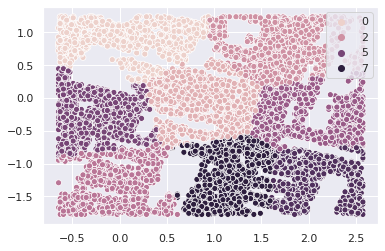

In [308]:
sns.scatterplot(test_y[:,0], test_y[:,1], hue=test_labels)


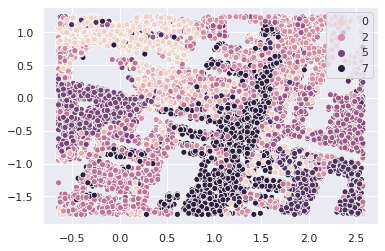

In [309]:
predicted_labels = labels.argmax(dim=1)
sns.scatterplot(test_y[:,0], test_y[:,1], hue=predicted_labels)


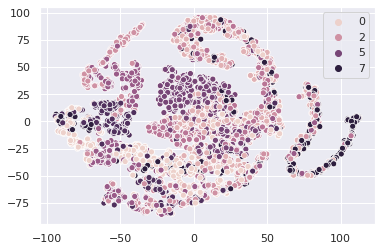

In [310]:
sns.scatterplot(yhats_TSNE[:,0], yhats_TSNE[:,1], 
                hue=test_labels, 
                color='r', alpha=1) 

In [311]:
print(classification_report(predicted_labels, test_labels))

              precision    recall  f1-score   support

           0       0.70      0.58      0.64       872
           1       0.19      0.64      0.30       270
           2       0.63      0.60      0.61       922
           3       0.72      0.45      0.56      1110
           4       0.66      0.76      0.71       604
           5       0.69      0.89      0.78       591
           6       0.68      0.86      0.76       451
           7       0.71      0.44      0.55      1119

    accuracy                           0.61      5939
   macro avg       0.62      0.65      0.61      5939
weighted avg       0.66      0.61      0.62      5939



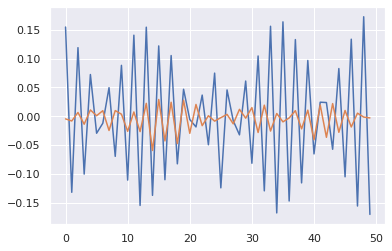

In [312]:
plt.plot(test_DS[0][0][0])
plt.plot(reconstructed[0][0].detach())